In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.display import HTML

import os
import itertools
import gc
import pickle
import random

import numpy as np
import pandas as pd
import pandas_summary as pds
import seaborn as sns

from zillow import *
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


# Training & Testing w/ XGBoost

In [2]:
zdata = None
xgb = None

In [47]:
if xgb is not None:
    del xgb
if zdata is not None:
    del zdata
gc.collect()
zdata = DataLoader()
xgb = XGB(zdata)

In [51]:
_ = xgb.train(verbose_eval=200)

[0]	train-mae:0.489811	valid-mae:0.487113
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[200]	train-mae:0.181027	valid-mae:0.189511
[400]	train-mae:0.078498	valid-mae:0.093743
[600]	train-mae:0.05137	valid-mae:0.069604
[800]	train-mae:0.04602	valid-mae:0.065571
[1000]	train-mae:0.04501	valid-mae:0.065085
[1200]	train-mae:0.044764	valid-mae:0.065029
[1400]	train-mae:0.044667	valid-mae:0.065015
[1600]	train-mae:0.044608	valid-mae:0.065001
[1800]	train-mae:0.044559	valid-mae:0.064983
[2000]	train-mae:0.044517	valid-mae:0.064972
[2200]	train-mae:0.044479	valid-mae:0.064963
[2400]	train-mae:0.044446	valid-mae:0.064955
[2600]	train-mae:0.044411	valid-mae:0.064945
[2800]	train-mae:0.044377	valid-mae:0.064939
Stopping. Best iteration:
[2718]	train-mae:0.04439	valid-mae:0.064939

[2718]	train-mae:0.04439	valid-mae:0.064939


In [4]:
zdata.transactions()['logerror'].describe()

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

In [46]:
t = zdata.transactions()
t.loc[t.logerror.abs() <= 2*t.logerror.std(), ['logerror']].describe()

,logerror
count,87583.000000
mean,0.006514
std,0.075046
min,-0.321600
25%,-0.025300
50%,0.005000
75%,0.036300
max,0.322100


In [45]:
t['logerror'].quantile(.025)

-0.2021

# Baseline MAE = 0.064939

In [45]:
params = {
    'eta': 0.005,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'max_depth': 8,
    'silent': 1,
    'subsample': 0.5,
    'colsample_bytree': 0.2,
    'min_child_weight': 8,
    'lambda': 2,
}

In [70]:
params = {
    'eta': 0.005,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'max_depth': 8,
    'silent': 1,
    'subsample': 0.5,
    'colsample_bytree': 0.2,
    'min_child_weight': 8,
    'lambda': 2,
}

_ = xgb.train(params=params, verbose_eval=200)

[0]	train-mae:0.489811	valid-mae:0.487112
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[200]	train-mae:0.181044	valid-mae:0.189624
[400]	train-mae:0.078443	valid-mae:0.094563
[600]	train-mae:0.050843	valid-mae:0.070079
[800]	train-mae:0.045131	valid-mae:0.065645
[1000]	train-mae:0.043841	valid-mae:0.064962
[1200]	train-mae:0.043363	valid-mae:0.064843
[1400]	train-mae:0.043059	valid-mae:0.064796
[1600]	train-mae:0.042809	valid-mae:0.06478
[1800]	train-mae:0.042586	valid-mae:0.064767
[2000]	train-mae:0.04236	valid-mae:0.064754
Stopping. Best iteration:
[2002]	train-mae:0.042358	valid-mae:0.064753

[2002]	train-mae:0.042358	valid-mae:0.064753


# 0.064753

In [71]:
_ = xgb.predict()

Predicting... 201610
Predicting... 201611
Predicting... 201612
Predicting... 201710
Predicting... 201711
Predicting... 201712


In [5]:
def filter_columns(missing):
    vals = describe_values(zdata.properties())
    return set(vals.loc[vals['missing %'] > missing]['column'])
cols_high_missing = filter_columns(missing=90)
cols_high_missing

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/ipykernel_launcher.py:4: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  after removing the cwd from sys.path.


{'architecturalstyletypeid',
 'basementsqft',
 'buildingclasstypeid',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplaceflag',
 'hashottuborspa',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'storytypeid',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'typeconstructiontypeid',
 'yardbuildingsqft17',
 'yardbuildingsqft26'}

In [6]:
params = {
    'eta': 0.005,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'max_depth': 3,
    'silent': 1,
    'subsample': 0.5,
    'colsample_bytree': 0.2,
    'min_child_weight': 4,
    'lambda': 2,
}

_ = xgb.train(params=params, verbose_eval=200, dropcols=cols_high_missing)

[0]	train-mae:0.490149	valid-mae:0.487114
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[200]	train-mae:0.186549	valid-mae:0.189346
[400]	train-mae:0.087376	valid-mae:0.09376
[600]	train-mae:0.061226	valid-mae:0.069789
[800]	train-mae:0.056029	valid-mae:0.065758
[1000]	train-mae:0.055017	valid-mae:0.065251
[1200]	train-mae:0.054765	valid-mae:0.065189
[1400]	train-mae:0.054662	valid-mae:0.065174
[1600]	train-mae:0.054604	valid-mae:0.065164
[1800]	train-mae:0.054559	valid-mae:0.065158
[2000]	train-mae:0.054518	valid-mae:0.065146
Stopping. Best iteration:
[1951]	train-mae:0.054527	valid-mae:0.065146

[1951]	train-mae:0.054527	valid-mae:0.065146


In [3]:
p = zdata.properties()
cln = pd.DataFrame()

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [30]:
c = 'airconditioningtypeid'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
cln[c].unique()

array([ nan,   1.,  13.,   5.,  11.,   9.,  12.,   3.])

array(['0', '1', '13', '5', '11', '9', '12', '3'], dtype=object)

In [33]:
c = 'architecturalstyletypeid'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
cln[c].unique()

array([ nan,   7.,  21.,   8.,   2.,   3.,   5.,  10.,  27.])

array(['0', '7', '21', '8', '2', '3', '5', '10', '27'], dtype=object)

In [121]:
summarize(p[['architecturalstyletypeid', 'airconditioningtypeid']])

,architecturalstyletypeid,airconditioningtypeid
count,6061,811519
mean,7.20261,1.93117
std,2.43629,3.14859
min,2,1
25%,7,1
50%,7,1
75%,7,1
max,27,13
counts,6061,811519
uniques,8,7


In [34]:
c = 'basementsqft'
cln[c] = p[c].fillna(0).astype('float32')

In [54]:
c = 'bathroomcnt'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].mode()[0]).astype('float32')
cln[c].unique()
p[c].mode()[0]

array([  0.  ,   2.  ,   4.  ,   3.  ,   1.  ,   2.5 ,   3.5 ,   5.  ,
         1.5 ,   4.5 ,   7.5 ,   5.5 ,   6.  ,   7.  ,  10.  ,   8.  ,
         9.  ,  12.  ,  11.  ,   8.5 ,   6.5 ,  13.  ,   9.5 ,  14.  ,
        20.  ,  19.5 ,  15.  ,  10.5 ,    nan,  18.  ,  16.  ,   1.75,
        17.  ,  19.  ,   0.5 ,  12.5 ,  11.5 ,  14.5 ])

2.0

In [44]:
c = 'bedroomcnt'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].mode()[0]).astype('int')
display(cln[c].unique())
p[c].mode()[0]

array([  0.,   4.,   5.,   2.,   3.,   1.,   6.,   7.,   8.,  12.,  11.,
         9.,  10.,  14.,  16.,  13.,  nan,  15.,  17.,  18.,  20.,  19.])

array([ 0,  4,  5,  2,  3,  1,  6,  7,  8, 12, 11,  9, 10, 14, 16, 13, 15,
       17, 18, 20, 19])

3.0

In [48]:
c = 'buildingclasstypeid'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
display(cln[c].unique())

array([ nan,   3.,   4.,   5.,   2.,   1.])

array(['0', '3', '4', '5', '2', '1'], dtype=object)

In [49]:
c = 'buildingqualitytypeid'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
display(cln[c].unique())

array([ nan,   7.,   4.,  10.,   1.,  12.,   8.,   3.,   6.,   9.,   5.,
        11.,   2.])

array(['0', '7', '4', '10', '1', '12', '8', '3', '6', '9', '5', '11', '2'], dtype=object)

In [77]:
c = 'calculatedbathnbr'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('float32')
display(cln[c].unique())
display(p[c].mode())

array([  nan,   2. ,   4. ,   3. ,   1. ,   2.5,   3.5,   5. ,   1.5,
         4.5,   7.5,   5.5,   6. ,   7. ,  10. ,   8. ,   9. ,  12. ,
        11. ,   8.5,   6.5,  13. ,   9.5,  14. ,  20. ,  19.5,  15. ,
        10.5,  18. ,  16. ,  17. ,  19. ,  12.5,  11.5,  14.5])

array([  0. ,   2. ,   4. ,   3. ,   1. ,   2.5,   3.5,   5. ,   1.5,
         4.5,   7.5,   5.5,   6. ,   7. ,  10. ,   8. ,   9. ,  12. ,
        11. ,   8.5,   6.5,  13. ,   9.5,  14. ,  20. ,  19.5,  15. ,
        10.5,  18. ,  16. ,  17. ,  19. ,  12.5,  11.5,  14.5])

0    2.0
dtype: float64

In [75]:
c = 'threequarterbathnbr'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int')
display(cln[c].unique())

array([ nan,   1.,   2.,   4.,   3.,   6.,   5.,   7.])

array([0, 1, 2, 4, 3, 6, 5, 7])

In [76]:
c = 'fullbathcnt'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int')
display(cln[c].unique())

array([ nan,   2.,   4.,   3.,   1.,   5.,   7.,   6.,  10.,   8.,   9.,
        12.,  11.,  13.,  14.,  20.,  19.,  15.,  18.,  16.,  17.])

array([ 0,  2,  4,  3,  1,  5,  7,  6, 10,  8,  9, 12, 11, 13, 14, 20, 19,
       15, 18, 16, 17])

In [80]:
cln.loc[cln.calculatedbathnbr != cln.fullbathcnt + cln.threequarterbathnbr/2, ['calculatedbathnbr']]

,calculatedbathnbr


In [86]:
summarize(cln.loc[cln.calculatedbathnbr != cln.bathroomcnt, ['calculatedbathnbr', 'bathroomcnt', 'fullbathcnt', 'threequarterbathnbr']])

,calculatedbathnbr,bathroomcnt,fullbathcnt,threequarterbathnbr
count,12298,12298,12298,12298
mean,0,2.03108,0,0
std,0,0.344945,0,0
min,0,0.5,0,0
25%,0,2,0,0
50%,0,2,0,0
75%,0,2,0,0
max,0,8.5,0,0
counts,12298,12298,12298,12298
uniques,1,12,1,1


In [82]:
summarize(cln[['calculatedbathnbr', 'bathroomcnt', 'fullbathcnt', 'threequarterbathnbr']])

,calculatedbathnbr,bathroomcnt,fullbathcnt,threequarterbathnbr
count,2.98522e+06,2.98522e+06,2.98522e+06,2.98522e+06
mean,2.19997,2.20834,2.14725,0.105436
std,1.08474,1.07576,1.07152,0.311161
min,0,0,0,0
25%,2,2,2,0
50%,2,2,2,0
75%,3,3,3,0
max,20,20,20,7
counts,2985217,2985217,2985217,2985217
uniques,35,37,21,8


In [89]:
c = 'decktypeid'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
display(cln[c].unique())

array([ nan,  66.])

array(['0', '66'], dtype=object)

In [92]:
c = 'finishedfloor1squarefeet'
cln[c] = p[c].fillna(0).astype('float32')
c = 'calculatedfinishedsquarefeet'
cln[c] = p[c].fillna(0).astype('float32')
c = 'finishedsquarefeet12'
cln[c] = p[c].fillna(0).astype('float32')
c = 'finishedsquarefeet13'
cln[c] = p[c].fillna(0).astype('float32')
c = 'finishedsquarefeet15'
cln[c] = p[c].fillna(0).astype('float32')
c = 'finishedsquarefeet50'
cln[c] = p[c].fillna(0).astype('float32')
c = 'finishedsquarefeet6'
cln[c] = p[c].fillna(0).astype('float32')

In [93]:
c = 'fips'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
display(cln[c].unique())

array([ 6037.,  6059.,  6111.,    nan])

array(['6037', '6059', '6111', '0'], dtype=object)

In [99]:
c = 'fireplacecnt'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int')
display(cln[c].unique())

array([ nan,   3.,   1.,   2.,   4.,   9.,   5.,   7.,   6.,   8.])

array([0, 3, 1, 2, 4, 9, 5, 7, 6, 8])

In [100]:
c = 'garagecarcnt'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].mode()[0]).astype('int')
display(cln[c].unique())
display(p[c].mode())

array([ nan,   2.,   4.,   1.,   3.,   0.,   5.,   7.,   6.,   8.,   9.,
        12.,  11.,  10.,  13.,  14.,  15.,  25.,  21.,  18.,  17.,  24.,
        19.,  16.,  20.])

array([ 2,  4,  1,  3,  0,  5,  7,  6,  8,  9, 12, 11, 10, 13, 14, 15, 25,
       21, 18, 17, 24, 19, 16, 20])

0    2.0
dtype: float64

In [101]:
c = 'garagetotalsqft'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('float32')
display(cln[c].unique())
display(p[c].mode())

array([   nan,   420.,   525., ...,  2482.,  4568.,  1974.])

array([    0.,   420.,   525., ...,  2482.,  4568.,  1974.])

0    0.0
dtype: float64

In [102]:
c = 'hashottuborspa'
display(p[c].unique())
cln[c] = p[c] == True
display(cln[c].unique())
display(p[c].mode())

array([nan, True], dtype=object)

array([False,  True], dtype=bool)

0    True
dtype: object

In [104]:
c = 'heatingorsystemtypeid'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
display(cln[c].unique())
display(p[c].mode())

array([ nan,   2.,   7.,  20.,   6.,  13.,  18.,  24.,  12.,  10.,   1.,
        14.,  21.,  11.,  19.])

array(['0', '2', '7', '20', '6', '13', '18', '24', '12', '10', '1', '14',
       '21', '11', '19'], dtype=object)

0    2.0
dtype: float64

In [105]:
c = 'latitude'
cln[c] = p[c].fillna(p[c].mean()).astype('float32')
c = 'longitude'
cln[c] = p[c].fillna(p[c].mean()).astype('float32')

In [108]:
c = 'lotsizesquarefeet'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].median()).astype('float32')
display(cln[c].unique())
display(p[c].median())

array([  8.57680000e+04,   4.08300000e+03,   6.30850000e+04, ...,
         4.18010000e+04,   6.97900000e+04,   7.03415300e+06])

array([  8.57680000e+04,   4.08300000e+03,   6.30850000e+04, ...,
         4.18010000e+04,   6.97900000e+04,   7.03415300e+06])

7000.0

In [112]:
c = 'poolcnt'
cln[c] = p[c].fillna(0).astype('int')
c = 'poolsizesum'
cln[c] = p[c].fillna(0).astype('float32')
c = 'pooltypeid10'
cln[c] = p[c].fillna(0).astype('int').astype('str')
c = 'pooltypeid2'
cln[c] = p[c].fillna(0).astype('int').astype('str')
c = 'pooltypeid7'
cln[c] = p[c].fillna(0).astype('int').astype('str')

In [116]:
c = 'propertycountylandusecode'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].mode()[0]).astype('str')
display(cln[c].unique())

array(['010D', '0109', '1200', '1210', '010V', '300V', '0100', '0200',
       '010C', '0300', '1204', '100V', '01HC', '120C', '040V', '1214',
       '0101', nan, '070P', '0700', '1', '128', '0', '1112', '5050',
       '1110', '1118', '010E', '1111', '1129', '1420', '1222', '1128',
       '1310', '1117', '1333', '1116', '1410', '0104', '070D', '0108',
       '012C', '0400', '0103', '01DC', '0201', '010M', '030V', '0110',
       '010F', '010G', '010H', '0301', '0102', '020E', '020M', '0401',
       '0113', '0141', '122', '38', '135', '96', '71', '73', '34', '0209',
       '040G', '010L', '012E', '0111', '1720', '1014', '012D', '1213',
       '1201', '1321', '1444', '1421', '0140', '0123', '0133', '020G',
       '030G', '105', '0204', '010T', '0120', '1202', '121G', '010X',
       '020V', '880V', '1120', '0130', '0118', '01HE', '120G', '5060',
       '0131', '0203', '011C', '1215', '1212', '040D', '120T', '0420', '8',
       '1203', '070X', '0114', '030E', '121T', '1012', '121C', '0105', 

array(['010D', '0109', '1200', '1210', '010V', '300V', '0100', '0200',
       '010C', '0300', '1204', '100V', '01HC', '120C', '040V', '1214',
       '0101', '070P', '0700', '1', '128', '0', '1112', '5050', '1110',
       '1118', '010E', '1111', '1129', '1420', '1222', '1128', '1310',
       '1117', '1333', '1116', '1410', '0104', '070D', '0108', '012C',
       '0400', '0103', '01DC', '0201', '010M', '030V', '0110', '010F',
       '010G', '010H', '0301', '0102', '020E', '020M', '0401', '0113',
       '0141', '122', '38', '135', '96', '71', '73', '34', '0209', '040G',
       '010L', '012E', '0111', '1720', '1014', '012D', '1213', '1201',
       '1321', '1444', '1421', '0140', '0123', '0133', '020G', '030G',
       '105', '0204', '010T', '0120', '1202', '121G', '010X', '020V',
       '880V', '1120', '0130', '0118', '01HE', '120G', '5060', '0131',
       '0203', '011C', '1215', '1212', '040D', '120T', '0420', '8', '1203',
       '070X', '0114', '030E', '121T', '1012', '121C', '0105', '5', 

In [117]:
c = 'propertylandusetypeid'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].mode()[0]).astype('str')
display(cln[c].unique())

array([ 269.,  261.,   47.,   31.,  260.,  266.,  246.,  247.,  248.,
        263.,  265.,  275.,  267.,  264.,  270.,   nan])

array(['269.0', '261.0', '47.0', '31.0', '260.0', '266.0', '246.0',
       '247.0', '248.0', '263.0', '265.0', '275.0', '267.0', '264.0',
       '270.0'], dtype=object)

In [118]:
c = 'propertyzoningdesc'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].mode()[0]).astype('str')
display(cln[c].unique())

array([nan, 'LCA11*', 'LAC2', ..., 'WCR1400000', 'EMPYYY', 'RMM2*'], dtype=object)

array(['LAR1', 'LCA11*', 'LAC2', ..., 'WCR1400000', 'EMPYYY', 'RMM2*'], dtype=object)

In [126]:
c = 'rawcensustractandblock'
display(p[c].unique())
cln[c] = p[c].astype('str').replace('nan', None)
display(cln[c].unique())

array([ 60378002.041   ,  60378001.011002,  60377030.012017, ...,
        60590626.211013,  60379012.091563,              nan])

array(['60378002.041', '60378001.011', '60377030.012', ...,
       '60375323.0331', '60375039.0221', '60376024.03'], dtype=object)

In [130]:
c = 'regionidcity'
cln[c] = p[c].fillna(0).astype('int').astype('str')
c = 'regionidcounty'
cln[c] = p[c].fillna(0).astype('int').astype('str')
c = 'regionidneighborhood'
cln[c] = p[c].fillna(0).astype('int').astype('str')
c = 'regionidzip'
cln[c] = p[c].fillna(0).astype('int').astype('str')

In [133]:
c = 'roomcnt'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].mode()[0]).astype('int')
display(cln[c].unique())
display(p[c].mode()[0])

array([  0.,   8.,   4.,   5.,   7.,   6.,  11.,   3.,  10.,   9.,   2.,
        12.,  86.,  13.,  15.,  18.,  22.,  14.,   1.,  19.,  nan,  21.,
        30.,  16.,  67.,  56.,  42.,  17.,  24.,  84.,  20.,  31.,  77.,
        40.,  52.,  96.,  45.])

array([ 0,  8,  4,  5,  7,  6, 11,  3, 10,  9,  2, 12, 86, 13, 15, 18, 22,
       14,  1, 19, 21, 30, 16, 67, 56, 42, 17, 24, 84, 20, 31, 77, 40, 52,
       96, 45])

0.0

In [135]:
c = 'storytypeid'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
display(cln[c].unique())

array([ nan,   7.])

array(['0', '7'], dtype=object)

In [11]:
c = 'typeconstructiontypeid'
display(p[c].unique())
cln[c] = p[c].fillna(0).astype('int').astype('str')
display(cln[c].unique())

array([ nan,   6.,   4.,  10.,  13.,  11.])

array(['0', '6', '4', '10', '13', '11'], dtype=object)

In [136]:
c = 'unitcnt'
display(p[c].unique())
cln[c] = p[c].fillna(p[c].mode()[0]).astype('int')
display(cln[c].unique())

array([  nan,    2.,    1.,    3.,    5.,    4.,    9.,   48.,   13.,
         22.,   26.,   73.,   16.,   12.,    6.,    7.,   29.,   35.,
        127.,   18.,    8.,   10.,  199.,   11.,   77.,   69.,   21.,
        138.,   33.,   36.,   14.,  196.,  214.,   51.,   30.,   20.,
        211.,  421.,   27.,   90.,   28.,   80.,   24.,   32.,  131.,
        238.,  883.,   75.,   74.,  120.,   37.,   19.,   17.,  143.,
        464.,   98.,   42.,   52.,   65.,   23.,   25.,  951.,   15.,
        100.,   58.,  865.,  111.,   41.,   38.,  679.,  144.,   78.,
         39.,  237.,   45.,   44.,  151.,  156.,   50.,   70.,   31.,
         63.,  125.,  132.,   43.,   72.,  134.,  101.,  693.,  623.,
         49.,   40.,  614.,  112.,  186.,   54.,  206.,   66.,  685.,
         55.,   96.,   59.,   56.,  232.,   34.,  149.,   87.,   60.,
        386.,   46.,  113.,  376.,  252.,  256.,   68.,  502.,  279.,
        303.,  114.,  401.,  105.,  524.,  383.,   79.,   85.,   93.,
         53.,   84.,

array([  1,   2,   3,   5,   4,   9,  48,  13,  22,  26,  73,  16,  12,
         6,   7,  29,  35, 127,  18,   8,  10, 199,  11,  77,  69,  21,
       138,  33,  36,  14, 196, 214,  51,  30,  20, 211, 421,  27,  90,
        28,  80,  24,  32, 131, 238, 883,  75,  74, 120,  37,  19,  17,
       143, 464,  98,  42,  52,  65,  23,  25, 951,  15, 100,  58, 865,
       111,  41,  38, 679, 144,  78,  39, 237,  45,  44, 151, 156,  50,
        70,  31,  63, 125, 132,  43,  72, 134, 101, 693, 623,  49,  40,
       614, 112, 186,  54, 206,  66, 685,  55,  96,  59,  56, 232,  34,
       149,  87,  60, 386,  46, 113, 376, 252, 256,  68, 502, 279, 303,
       114, 401, 105, 524, 383,  79,  85,  93,  53,  84, 888,  83, 997,
        91,  76, 181,  97,  62, 583, 246, 102, 708, 179, 332, 224, 118,
        61,  88, 130])

In [137]:
c = 'yardbuildingsqft17'
cln[c] = p[c].fillna(0).astype('float32')
c = 'yardbuildingsqft26'
cln[c] = p[c].fillna(0).astype('float32')

In [ ]:
c = 'yearbuilt'
cln[c] = p[c].fillna(2016).astype('int')

In [139]:
c = 'numberofstories'
cln[c] = p[c].fillna(p[c].mode()[0]).astype('int')

In [142]:
c = 'fireplaceflag'
cln[c] = p[c] == True
display(cln[c].unique())

array([False,  True], dtype=bool)

In [142]:
c = 'structuretaxvaluedollarcnt'
cln[c] = p[c].fillna(0).astype('float32')

c = 'taxvaluedollarcnt'
cln[c] = p[c].fillna(0).astype('float32')

c = 'landtaxvaluedollarcnt'
cln[c] = p[c].fillna(0).astype('float32')

c = 'taxamount'
cln[c] = p[c].fillna(0).astype('float32')

array([False,  True], dtype=bool)

In [10]:
c = 'assessmentyear'
display(p[c].unique())
cln[c] = p[c].fillna(2017).astype('int')

array([ 2015.,  2014.,  2003.,  2012.,  2001.,  2011.,  2013.,  2016.,
        2010.,    nan,  2004.,  2005.,  2002.,  2000.,  2009.])

In [150]:
c = 'taxdelinquencyflag'
cln[c] = p[c] == 'Y'

array([False,  True], dtype=bool)

In [172]:
c = 'taxdelinquencyyear'
cln[c] = p[c]
cln.loc[p[c] < 70, c] = cln[p[c] < 70][c] + 2000
cln.loc[p[c] >= 70, c] = cln[p[c] >= 70][c] + 1900
cln[c] = cln[c].fillna(2016).astype('int')
s = cln[c].unique()
s.sort()
s

array([1979, 1982, 1984, 1986, 1987, 1988, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

In [12]:
describe_values(zdata.properties())

,column,dtype,sample,unique len,missing %
57,parcelid,int64,"[10754147, 10759547, 10843547]",2985217,0.000000
56,airconditioningtypeid,float64,"[1.0, 3.0, 5.0]",8,72.815410
55,architecturalstyletypeid,float64,"[2.0, 3.0, 5.0]",9,99.796966
54,basementsqft,float64,"[20.0, 24.0, 25.0]",752,99.945465
53,bathroomcnt,float64,"[0.0, 0.5, 1.0]",38,0.383959
52,bedroomcnt,float64,"[0.0, 1.0, 2.0]",22,0.383557
51,buildingclasstypeid,float64,"[1.0, 2.0, 3.0]",6,99.576949
50,buildingqualitytypeid,float64,"[1.0, 2.0, 3.0]",13,35.063749
49,calculatedbathnbr,float64,"[1.0, 1.5, 2.0]",35,4.318346
48,decktypeid,float64,"[66.0, nan]",2,99.427311


In [173]:
describe_values(cln)

,column,dtype,sample,unique len,missing %
49,airconditioningtypeid,object,"[0, 1, 13]",8,0.0
48,architecturalstyletypeid,object,"[0, 7, 21]",9,0.0
47,basementsqft,float32,"[0.0, 20.0, 24.0]",752,0.0
46,bathroomcnt,float32,"[0.0, 0.5, 1.0]",37,0.0
45,bedroomcnt,int64,"[0, 4, 5]",21,0.0
44,buildingclasstypeid,object,"[0, 3, 4]",6,0.0
43,buildingqualitytypeid,object,"[0, 7, 4]",13,0.0
42,calculatedbathnbr,float32,"[0.0, 1.0, 1.5]",35,0.0
41,threequarterbathnbr,int64,"[0, 1, 2]",8,0.0
40,fullbathcnt,int64,"[0, 2, 4]",21,0.0


# 0.065144

In [3]:
params = {
    'eta': 0.005,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'max_depth': 8,
    'silent': 1,
    'subsample': 0.7,
    'colsample_bytree': 0.2,
    'min_child_weight': 6,
    'lambda': 2,
}

def recursive_feature_selection(cols, dropcols=None, reverse=False):
    if dropcols == None:
        dropcols = from_pickle('zillow/dropcols.pkl')
    if dropcols == None:
        dropcols = set()
    if cols is None:
        cols = set(zdata.preprocessed.properties().columns)
    cols = cols - dropcols
    clf, _ = xgb.train(params=params, dropcols=dropcols)
    mae = float(clf.attr('best_score'))
    mae_best = mae
    mae_best_pass = mae
    dropc = None

    i = 0
    while True:
        i += 1
        print ('Pass: ', i)
        for c in cols:
            print ('Evaluating: ', c)
            if reverse:
                clf, _ = xgb.train(params=params, dropcols=dropcols - set([c]))
            else:
                clf, _ = xgb.train(params=params, dropcols=dropcols | set([c]))
            mae = float(clf.attr('best_score'))
            if mae < mae_best_pass:
                mae_best_pass = mae
                dropc = c
            print ('Best MAE: {} - {}'.format(dropc, mae_best_pass))
        if mae_best_pass >= mae_best:
            print ('No more improvements')
            break
        else:
            print ('Dropping: ', dropc)
            print ('Best MAE: ', mae_best_pass)
            if reverse:
                cols.add(dropc)
                dropcols.remove(dropc)
            else:
                cols.remove(dropc)
                dropcols.add(dropc)
            to_pickle(dropcols, 'zillow/dropcols.pkl')
            mae_best = mae_best_pass
    print (dropcols)    

In [4]:
cols = set(zdata.preprocessed.properties().columns)
recursive_feature_selection(cols, set(['parcelid', 'propertyzoningdesc', 
                                       'propertycountylandusecode', 'censustractandblock', 
                                       'rawcensustractandblock']))

[1228]	train-mae:0.052613	valid-mae:0.064933
Pass:  1
Evaluating:  block
[1273]	train-mae:0.052513	valid-mae:0.064964
Best MAE: None - 0.064933
Evaluating:  finishedsquarefeet6
[1276]	train-mae:0.052471	valid-mae:0.064956
Best MAE: None - 0.064933
Evaluating:  taxdelinquencyyear
[1277]	train-mae:0.0525	valid-mae:0.064942
Best MAE: None - 0.064933
Evaluating:  buildingclasstypeid
[1252]	train-mae:0.052542	valid-mae:0.064979
Best MAE: None - 0.064933
Evaluating:  decktypeid
[1273]	train-mae:0.05251	valid-mae:0.06497
Best MAE: None - 0.064933
Evaluating:  finishedsquarefeet12
[1276]	train-mae:0.052557	valid-mae:0.065003
Best MAE: None - 0.064933
Evaluating:  yardbuildingsqft26
[1276]	train-mae:0.05249	valid-mae:0.06493
Best MAE: yardbuildingsqft26 - 0.06493
Evaluating:  tractandblock
[1372]	train-mae:0.052342	valid-mae:0.064972
Best MAE: yardbuildingsqft26 - 0.06493
Evaluating:  storytypeid
[1277]	train-mae:0.052482	valid-mae:0.064919
Best MAE: storytypeid - 0.064919
Evaluating:  lon_adj_

[1302]	train-mae:0.052568	valid-mae:0.064954
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  tract
[1320]	train-mae:0.05251	valid-mae:0.064952
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  poolsizesum
[1301]	train-mae:0.052497	valid-mae:0.064944
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  heatingorsystemtypeid
[1409]	train-mae:0.052346	valid-mae:0.064931
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  bedroomcnt
[1315]	train-mae:0.052509	valid-mae:0.064937
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  taxamount
[1330]	train-mae:0.052808	valid-mae:0.065003
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  bathroomcnt
[1374]	train-mae:0.052391	valid-mae:0.064955
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  numberofstories
[1341]	train-mae:0.052455	valid-mae:0.064936
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  finishedsquarefeet13
[1374]	train-mae:0.052383	valid-mae:0.064954
Best MAE: taxvaluedollarcnt - 0.064906
Evaluating:  finishedsquarefeet

In [8]:
# dropcols = ['fips', 'tractandblock', 'roomcnt', 'bedroomcnt', 'taxdelinquencyyear', 'taxdelinquencyflag',
#             'lon_adj_fips', 'lat_adj_fips', 'distance_fips']
dropcols = ['taxvaluedollarcnt', 'taxdelinquencyyear', 'taxdelinquencyflag']
_ = xgb.train(params=params, dropcols=dropcols)

[1325]	train-mae:0.052488	valid-mae:0.06497


## Best MAE = 0.06569021621458694

In [24]:
from zillow import DataLoader
import gc

zillow_data = DataLoader()
gc.collect()
mrg = zillow_data.preprocessed.training()

In [15]:
cols = [c for c in mrg.columns if c.startswith('logerror')] + ['transaction_month', 'fips', 'parcelid']
describe_values(mrg.loc[:, cols])

,column,dtype,sample,unique len,missing %
20,logerror,float64,"[-4.605, -4.51, -3.194]",1894,0.0
19,logerror_abs,float64,"[0.0, 0.001, 0.002]",1821,0.0
18,logerror_fips_month_ave,float64,"[0.00742772188285, 0.00773489987239, 0.0080547...",36,0.0
17,logerror_abs_fips_month_ave,float64,"[0.0492815758637, 0.0500673080075, 0.050865567...",36,0.0
16,logerror_fips_month_med,float64,"[0.00410710232063, 0.00425876132159, 0.0044160...",36,0.0
15,logerror_abs_fips_month_med,float64,"[0.0243297577389, 0.024628251523, 0.0249304074...",36,0.0
14,logerror_fips_month_std,float64,"[0.13466805267, 0.134760329299, 0.135065250867]",36,0.0
13,logerror_abs_fips_month_std,float64,"[0.120873461108, 0.122703834977, 0.125268871931]",36,0.0
12,logerror_fips_month_var,float64,"[0.0177779323931, 0.0183197126293, 0.018436485...",36,0.0
11,logerror_abs_fips_month_var,float64,"[0.0144280642187, 0.0147720403919, 0.015540429...",36,0.0


In [84]:
txns = zillow_data.preprocessed.transactions()
logerror_month = txns.groupby(['transaction_month']).std().reset_index().drop('parcelid', axis=1)
txns['logerror'].mean()

0.011457219606757128

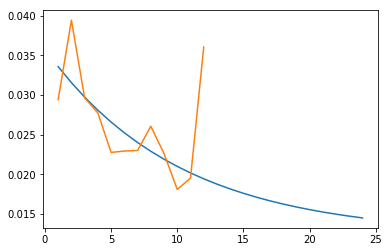

In [26]:
zdata = DataLoader()
gc.collect()

def plot_stat(trend, actual, stat):
    plt.plot(trend['transaction_month'], trend[stat])
    plt.plot(actual['transaction_month'], actual[stat])

trend = zdata.preprocessed.error_trend().groupby('transaction_month').mean().reset_index()
actual = zdata.preprocessed.error_month
plot_stat(trend, actual, 'logerror_month_var')

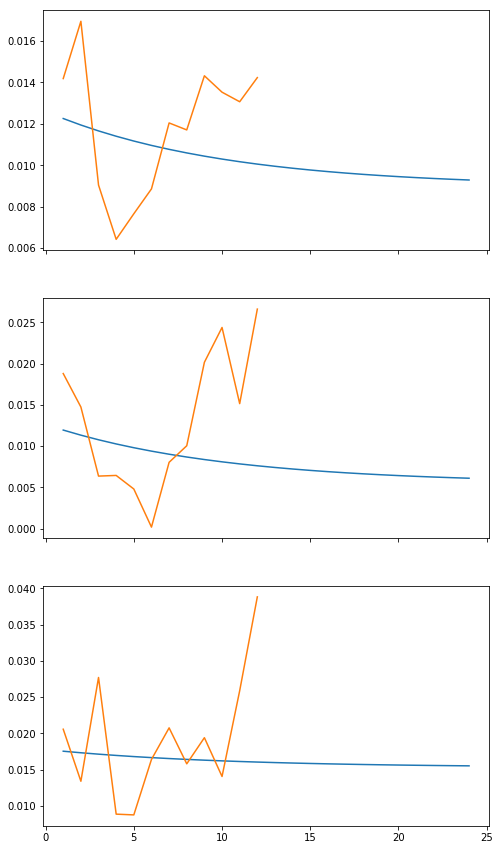

In [28]:
def plot_stat(trend, actual, stat, ax):
    ax.plot(trend['transaction_month'], trend[stat])
    ax.plot(actual['transaction_month'], actual[stat])

actual = zdata.preprocessed.error_fips_month
trend = zdata.preprocessed.error_trend()
ff, axes = plt.subplots(len(actual['fips'].unique()), sharex=True, figsize=(8,15))
for f, ax in zip(actual['fips'].unique(), axes):
    actual_fips = actual[actual['fips'] == f]
    trend_fips = trend[trend['fips'] == f]
    plot_stat(trend_fips, actual_fips, 'logerror_fips_month_ave', ax)

0.17180730467250735

0.14327251133993027

0.13989326523193055

0.15865108328460498

0.13352731483737715

0.10840354639014932

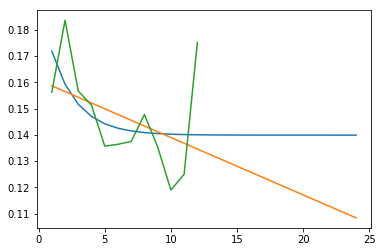

In [85]:
def plot(coefs):
    xs = range(1, 25)
    ys = [ coefs[0]*np.exp(-l*x)+coefs[1] for x in xs ]
    plt.plot(xs, ys)
    display(max(ys), np.mean(ys), min(ys))

def plot_linear(coefs):
    xs = range(1, 25)
    ys = [ coefs[0]*x+coefs[1] for x in xs ]
    plt.plot(xs, ys)
    display(max(ys), np.mean(ys), min(ys))
    
col = 'logerror_abs'
l = 0.5
coefs = np.polyfit(np.exp(-l*logerror_month['transaction_month']), logerror_month[col], 1)
plot(coefs)
coefs = np.polyfit(logerror_month['transaction_month'], logerror_month[col], 1)
plot_linear(coefs)
plt.plot(logerror_month['transaction_month'], logerror_month[col])

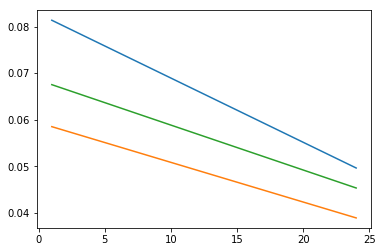

In [27]:
dl.logerror_fips_month
for f in dl.logerror_fips_month['fips'].unique():
    df = dl.logerror_fips_month[dl.logerror_fips_month['fips'] == f]
    plt.plot(df['transaction_month'], df['logerror_abs_fips_month_ave'])

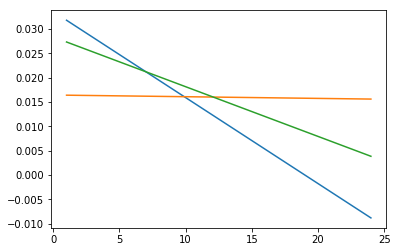

In [28]:
dl.logerror_fips_month
for f in dl.logerror_fips_month['fips'].unique():
    df = dl.logerror_fips_month[dl.logerror_fips_month['fips'] == f]
    plt.plot(df['transaction_month'], df['logerror_abs_fips_month_std'])

In [134]:
from zillow import *

In [10]:
zillow_data = DataLoader()
gc.collect()

349

In [92]:
def clr(epoch, lr_min=0.0001, lr_max=0.001, cycle=10):
    f = abs((epoch % cycle) - (cycle/2)) * 2 / cycle
    lr = lr_max - (lr_max - lr_min) * (1 - f)
    return lr

# for i in range(100):
#     print (clr(i))

clrs = keras.callbacks.LearningRateScheduler(clr)
mc = keras.callbacks.ModelCheckpoint('zillow/best_checkpoint.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
es = keras.callbacks.EarlyStopping(patience=20)
rlr = keras.callbacks.ReduceLROnPlateau(patience=1)

dropcols = set([
    'propertyzoningdesc', 
#    'propertycountylandusecode', 
    'censustractandblock', 
    'rawcensustractandblock',
#    'fips',
    'tractandblock',
    'roomcnt', 
    'bedroomcnt', 
    'taxdelinquencyflag',
    'taxdelinquencyyear',
])

nn = NeuralNet(zillow_data.preprocessed, dropcols=dropcols)
gc.collect()

334

In [93]:
nn.train(epochs=100, callbacks=[clrs, mc, es], verbose=1)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
architecturalstyletypeid_inp (In (None, 1)             0                                            
____________________________________________________________________________________________________
regionidcity_inp (InputLayer)    (None, 1)             0                                            
____________________________________________________________________________________________________
heatingorsystemtypeid_inp (Input (None, 1)             0                                            
____________________________________________________________________________________________________
propertycountylandusecode_inp (I (None, 1)             0                                            
___________________________________________________________________________________________

Train on 72158 samples, validate on 18117 samples
Epoch 1/100
 3584/72158 [>.............................] - ETA: 56s - loss: 0.1974

KeyboardInterrupt: 

In [80]:
nn.get_model().save_weights('zillow/0.065878423055811319.wgt')

In [94]:
nn.model = keras.models.load_model('zillow/best_checkpoint.wgt')
nn.test()

OSError: Unable to open file (Unable to open file: name = 'zillow/best_checkpoint.wgt', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [95]:
nn.model = keras.models.load_model('zillow/0.06564.model')
nn.model.summary()
nn.test()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
architecturalstyletypeid_inp (In (None, 1)             0                                            
____________________________________________________________________________________________________
regionidcity_inp (InputLayer)    (None, 1)             0                                            
____________________________________________________________________________________________________
heatingorsystemtypeid_inp (Input (None, 1)             0                                            
____________________________________________________________________________________________________
propertycountylandusecode_inp (I (None, 1)             0                                            
___________________________________________________________________________________________

0.065641815279478044

In [96]:
nn.predict()

Predicting... 201610
2985217/2985217 [==============================] - 1748s  


,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,-0.001329,-0.000543,0.000269,0.008086,0.008881,0.009745
1,10759547,-0.001574,-0.000820,-0.000006,0.008022,0.008818,0.009724
2,10843547,0.134220,0.133590,0.132912,0.125679,0.125206,0.124847
3,10859147,0.018415,0.018959,0.019369,0.023672,0.024511,0.025387
4,10879947,-0.051201,-0.050091,-0.048864,-0.034099,-0.032662,-0.031290
5,10898347,0.007533,0.008366,0.009145,0.017660,0.018737,0.019805
6,10933547,-0.001705,-0.000885,0.000024,0.009310,0.010286,0.011317
7,10940747,0.012630,0.013250,0.013843,0.020965,0.022000,0.022968
8,10954547,-0.002739,-0.002030,-0.001167,0.008384,0.009353,0.010333
9,10976347,0.012277,0.012595,0.012783,0.017663,0.018473,0.019373


# EDA

## Training, Properties and Submission Data

In [ ]:
dv = describe_values(dl.get_properties())

In [ ]:
dv[dv['missing %'] < 50]

In [ ]:
tx = 'transactiondate'
train = dl.get_training()
train = split_date(train, tx).drop(tx, axis=1)
train = train.pivot_table(columns='parcelid', index=['transactiondate_year', 'transactiondate_month'], values='logerror')
display(train)

In [ ]:
# how much data is missing?
display(train.isnull().sum().sum() / (train.shape[0]*train.shape[1]))

Most parcels have only 1 data point. Too much missing data to be useful on a per parcel basis.

In [ ]:
prop_parcels = set(dl.get_properties()['parcelid'])
subm_parcels = set(dl.get_submission()['ParcelId'])
trxn_parcels = set(dl.get_training()['parcelid'])
prp = dl.get_properties()
nodt_parcels = set(prp.loc[prp.rawcensustractandblock.isnull(), 'parcelid'])

# Are all properties required in the submission?
display(len(prop_parcels - subm_parcels) == 0)

# Do all properties have recorded transactions?
display(len(prop_parcels - trxn_parcels) == 0)

# How much of the submission is missing?
display(len(subm_parcels - trxn_parcels))

print(len(nodt_parcels & trxn_parcels), 'parcels have no data but have transactions')

Also some parcels have no property data!

## Logerror

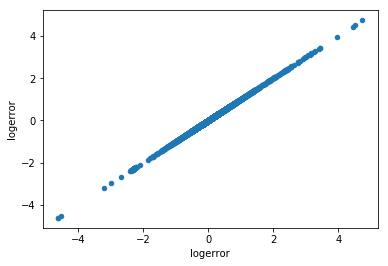

In [8]:
# check for outliers
pd.DataFrame(dl.get_training_preprocessed()['logerror']).plot.scatter(x='logerror', y='logerror')

In [ ]:
summarize(pd.DataFrame(dl.get_training()['logerror']))

In [13]:
# see if logerror varies per month

txm = 'transaction_month'
df = dl.get_training_preprocessed()

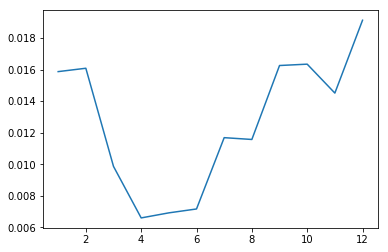

In [14]:
monthly = df[[txm, 'logerror']].groupby([txm])['logerror'].mean()
plt.plot(monthly.index, monthly)

In [ ]:
monthly = df[[txm, 'abs_logerror']].groupby([txm])['abs_logerror'].mean()
plt.ylim(0.06, 0.08)
plt.plot(monthly.index, monthly)

In [ ]:
def plot_monthly(df, grp, val):
    monthly = df.groupby([grp, txm])[val].mean()
    figs = len(monthly.index.levels[0])
    f, axes = plt.subplots(figs, 1, figsize=(8, figs*4), sharex=True, sharey=True)
    for g, ax in zip(monthly.index.levels[0], axes):
        plt.subplot(ax)
        plt.plot(monthly[g].index, monthly[g])

In [ ]:
plot_monthly(df, 'fips', 'logerror')

In [ ]:
plot_monthly(df, 'fips', 'abs_logerror')

In [ ]:
plot_monthly(df, 'regionidcounty', 'abs_logerror')

In [ ]:
monthly = df[[txm, 'abs_logerror']].groupby([txm])['abs_logerror'].mean()
monthly = monthly.reset_index()

In [ ]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha = .5)
reg.fit(monthly.drop('abs_logerror', axis=1), monthly['abs_logerror'])
preds = pd.DataFrame([ i for i in range(24)])
preds['abs_logerror'] = reg.predict(preds)

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(monthly.index, monthly['abs_logerror'])
plt.plot(preds.index, preds['abs_logerror'])

In [ ]:
sns.lmplot(x=txm, y="abs_logerror", data=monthly, ci=None, palette="muted")

In [ ]:
from sklearn import linear_model
lm = linear_model.Ridge(alpha = .5)

def regress(df, val):
    monthly = df.groupby(['fips', 'age'])[val].mean()
    preds = pd.DataFrame()
    for f in monthly.index.levels[0]:
        fip = monthly[f].reset_index()
        lm.fit(fip.drop(val, axis=1), fip[val])
        next_months = pd.DataFrame([ i for i in range(13, 25)], columns=['age'])
        next_months[val] = lm.predict(next_months)
        next_months['fips'] = f
#         display(next_months)
        preds = preds.append(next_months)
    preds = preds.append(monthly.reset_index())
    display(preds)

regress(df, 'abs_logerror')